# Set-up

In [1]:
# Read in the required packages
import gapminder, sys
import pandas as pd

# Importing altair  
import altair as alt # Core package
from vega_datasets import data as vega_data # Example datasets

# Render in a Jupyter notebook if not running in Colab
if 'google.colab' not in sys.modules:
    alt.renderers.enable('notebook')

# Reading in Data

In [2]:
# Define our dataframe
data = gapminder.gapminder

# Rounding values for easier display
data['lifeExp'] = round(data['lifeExp'] ,2)
data['gdpPercap'] = round(data['gdpPercap'] ,0)

data.head()

country continent  year  lifeExp       pop  gdpPercap
0  Afghanistan      Asia  1952    28.80   8425333      779.0
1  Afghanistan      Asia  1957    30.33   9240934      821.0
2  Afghanistan      Asia  1962    32.00  10267083      853.0
3  Afghanistan      Asia  1967    34.02  11537966      836.0
4  Afghanistan      Asia  1972    36.09  13079460      740.0

# Altair

In [4]:
# Defining an altair chart object
chart = alt.Chart(data)

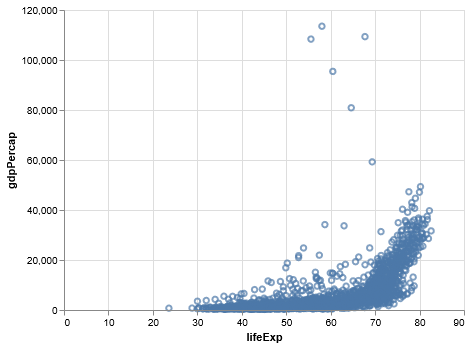

In [6]:
# Basic scatterplot
chart.mark_point().encode(x ='lifeExp', # Variable on x-axis
                          y='gdpPercap') # Variable on y-axis

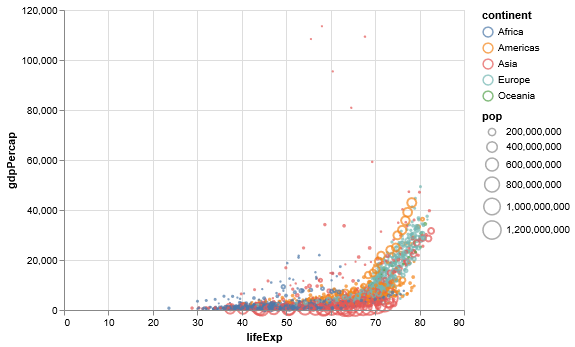

In [7]:
# Bubble Plot sized by population

chart\
    .mark_point()\
    .encode(x ='lifeExp', 
            y='gdpPercap', 
            size='pop', # Sizing dots by population
            color='continent') # Coloring dots by continent

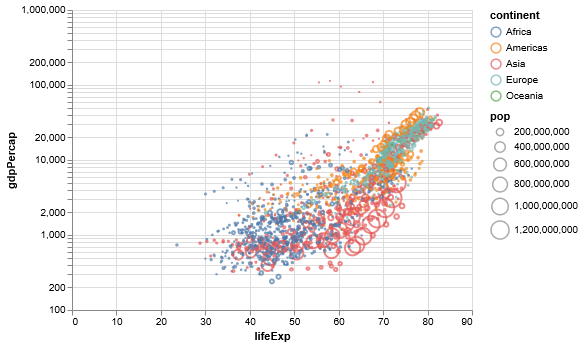

In [8]:
# Bubble Plot sized by population with logged y-axis

chart\
    .mark_point()\
    .encode(x ='lifeExp', 
            y=alt.Y('gdpPercap',scale=alt.Scale(type='log')), # Transforming the y-axis
            size='pop', 
            color='continent')

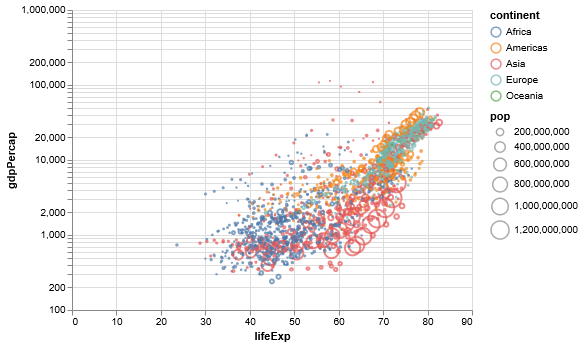

In [13]:
# Bubble Plot with Dynamic Tool-tip Functionality

chart\
    .mark_point()\
    .encode(x ='lifeExp', 
            y=alt.Y('gdpPercap',scale=alt.Scale(type='log')), 
            size='pop', 
            color='continent',
            tooltip='country') # Adding dynamic tool-tip functionality

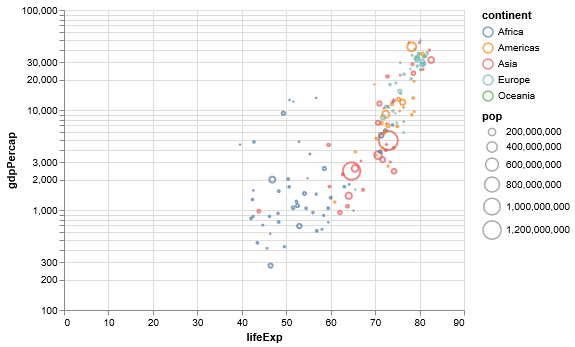

In [18]:
# Adding a slider to view data by year
slider = alt.binding_range(min=1952, max=2007, step=5)
select_year = alt.selection_single(name="year",
                                   fields=['year'], # Iterate over the year variable
                                   bind=slider, # Bind this selection to the slider object
                                   init={'year': 2007}) # Initialize the slider at 2007

chart\
    .mark_point()\
    .encode(x = alt.X('lifeExp', scale=alt.Scale( domain=(0,90))), # Freezing the axis so they don't move
            y=alt.Y('gdpPercap',scale=alt.Scale(type='log', domain=(100,100000))), # Freezing the axis so they don't move
            size='pop', 
            color='continent',
            tooltip='country:N')\
    .add_selection(select_year)\
    .transform_filter(select_year) # Adding the selection filter to the plot, transform based on the value of the slider

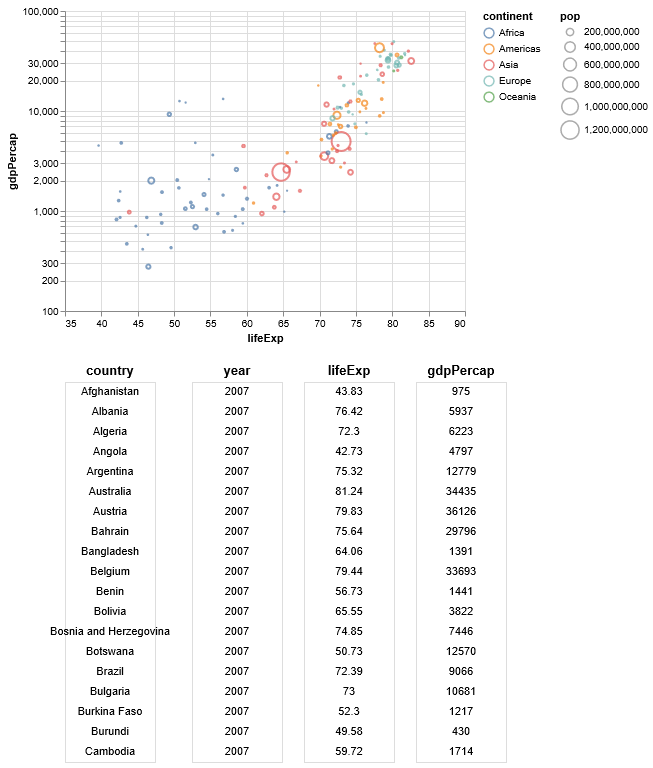

In [20]:
# Brushable Scatterplot with Dynamic Table
# Code adapted from: https://altair-viz.github.io/gallery/scatter_linked_table.html

# Starting with a fresh plot
chart = alt.Chart(data[data['year']==2007])

# Adding a brush for the scatterplot
brush = alt.selection(type='interval')

# Recreate the plot above
chart = chart\
    .mark_point()\
    .encode(x = alt.X('lifeExp', scale=alt.Scale( domain=(35,90))),
            y=alt.Y('gdpPercap',scale=alt.Scale(type='log', domain=(100,100000))),
            size='pop', 
            color='continent',
            tooltip='country:N')\
    .add_selection(brush) # Bind the brush selection feature to the chart object

# Create the data table ordered ascending by row number and return the top 20 records
ranked_text = alt.Chart(data[data['year']==2007]).mark_text().encode(
    y=alt.Y('row_number:O',axis=None)
            ).transform_window(
                row_number='row_number()'
            ).transform_filter(
                brush
            ).transform_window(
                rank='rank(row_number)'
            ).transform_filter(
                alt.datum.rank<20
            )

# Create each column separately and provide the correct labels
country = ranked_text.encode(text='country:N').properties(title='country')
year = ranked_text.encode(text='year:N').properties(title='year')
lifeExp = ranked_text.encode(text='lifeExp:N').properties(title='lifeExp')
gdpPercap = ranked_text.encode(text='gdpPercap:N').properties(title='gdpPercap')

# Concatenate all of the columns together into one table object
text = alt.hconcat(country, year, lifeExp, gdpPercap)

# Vertically combine the chart and the table
alt.vconcat(
    chart,
    text
).resolve_legend(
    color="independent"
)

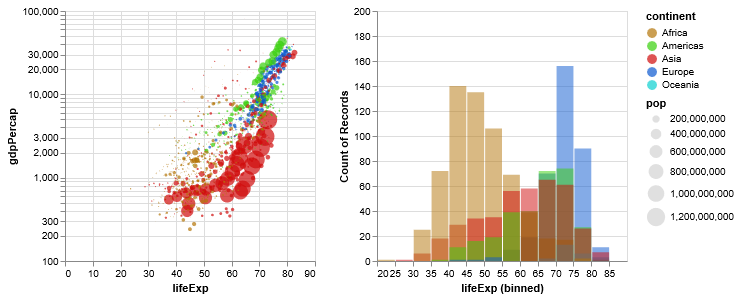

In [26]:
# Multiplot - Scatterplot & Histogram Combined
# Code adapted from https://altair-viz.github.io/gallery/scatter_with_layered_histogram.html

# Create a "single" (click) selector that will select all observations within the same continent 
selector = alt.selection_single(empty='all', fields=['continent'])

# Define a color scale using hex color values
color_scale = alt.Scale(domain=['Africa', 'Americas', 'Asia', 'Europe', 'Oceania'],
                        range=['#B47508', '#38D00B', '#D00B0B', '#0B59D0', '#0BD0D0'])

# Create a base chart and enable the click selector
base = alt.Chart(data).properties(
    width=250,
    height=250
    ).add_selection(selector)

# Take the base chart and make it a scatterplot
points = base.mark_point(filled=True).encode(
    x=alt.X('lifeExp',scale=alt.Scale(domain=[0,90])),                     # X axis and scale range
    y=alt.Y('gdpPercap',scale=alt.Scale(type='log', domain=(100,100000))), # Y axis, type, and scale range
    size='pop',                                                            # Size the dots according to population
    tooltip='country:N',                                                   # Use country as the tooltip
    color=alt.condition(selector,                                          # Assign colors using the dictionary above
                        'continent:N',
                        alt.value('lightgray'),
                        scale=color_scale),
    ).interactive() # Make the plot interactive

# Take the same base and make a histogram chart
hists = base.mark_bar(opacity=0.5, thickness=100).encode(
    x=alt.X('lifeExp',                                                     # Put life expectancy on the x-axis
            bin=alt.Bin(step=5),                                           # step keeps bin size the same
            scale=alt.Scale(domain=[20,90])),                              # Set the x-axis limits from 20-90
    y=alt.Y('count()',                                                     # Set the Y-axis to the count of countries
            stack=None,
            scale=alt.Scale(domain=[0,200])),                              # Set the scale from 0 to 200
    color=alt.Color('continent:N',                                         # Color the histogram by continent
                    scale=color_scale)                                     # Use the same color scale as above
    ).transform_filter(                                                    # Filter the histogram based on the selector value
        selector
    )


# Horizontally combine both plots
points | hists

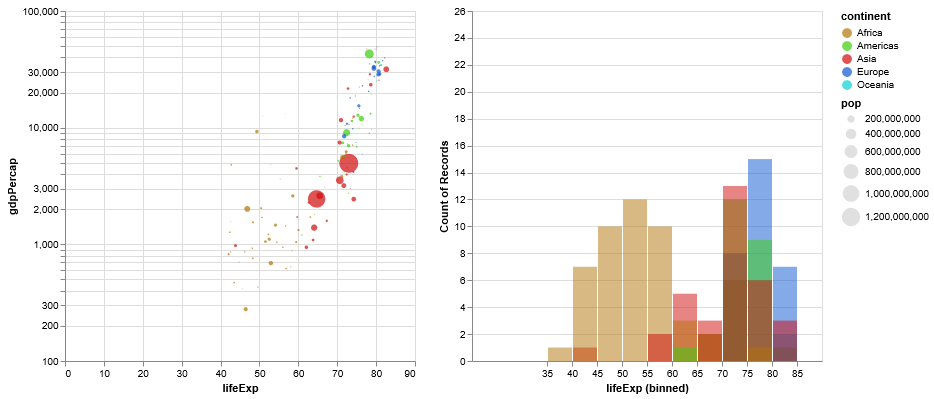

In [25]:
# Same plot as above, but adding a slider to view data by year

# Defining Year Slider
slider = alt.binding_range(min=1952, max=2007, step=5)
select_year = alt.selection_single(name="year", fields=['year'],
                                   bind=slider, init={'year': 2007})

selector = alt.selection_single(empty='all', fields=['continent'])

color_scale = alt.Scale(domain=['Africa', 'Americas', 'Asia', 'Europe', 'Oceania'],
                        range=['#B47508', '#38D00B', '#D00B0B', '#0B59D0', '#0BD0D0'])

base = alt.Chart(data).properties(
    width=350,
    height=350
).add_selection(selector)

points = base.mark_point(filled=True).encode(
    x=alt.X('lifeExp',scale=alt.Scale(domain=[0,90])),
    y=alt.Y('gdpPercap',scale=alt.Scale(type='log', domain=(100,100000))),
    size='pop',
    tooltip='country:N',
    color=alt.condition(selector,
                        'continent:N',
                        alt.value('lightgray'),
                        scale=color_scale),
    ).interactive()\
    .add_selection(select_year)\
    .transform_filter(select_year)

hists = base.mark_bar(opacity=0.5, thickness=100).encode(
    x=alt.X('lifeExp',
            bin=alt.Bin(step=5),
            scale=alt.Scale(domain=[20,90])),
    y=alt.Y('count()',
            stack=None,
            scale=alt.Scale(domain=[0,25])),
    color=alt.Color('continent:N',
                    scale=color_scale)
).transform_filter(
    selector
).transform_filter(select_year) # Add filter to view data by year


points | hists

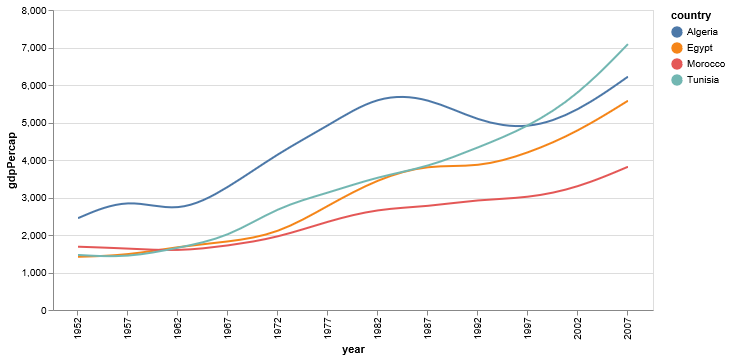

In [27]:
# Line Chart
# Code adapted from https://altair-viz.github.io/gallery/multiline_tooltip.html

temp = data[data['country'].isin(['Egypt','Lybia','Tunisia','Algeria','Morocco'])]

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['year'], empty='none')

# The basic line
line = alt.Chart(temp).mark_line(interpolate='basis').encode(
    x='year:O',
    y='gdpPercap:Q',
    color='country:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(temp).mark_point().encode(
    x='year:O',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=-40, dy=-5).encode(
    text=alt.condition(nearest, 'gdpPercap:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(temp).mark_rule(color='gray').encode(
    x='year:O',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)

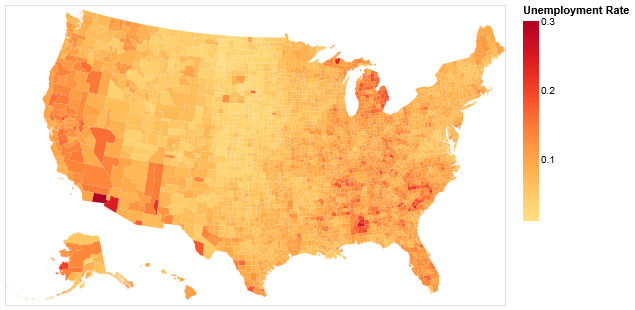

In [30]:
# US Map
# Code adapted from: https://altair-viz.github.io/gallery/choropleth.html

# Extract info on county level shapefiles
counties = alt.topo_feature(vega_data.us_10m.url, 'counties')

# Define source data
source = vega_data.unemployment.url

# Create an altair map
alt.Chart(counties).mark_geoshape().encode(
    tooltip=['id:N','rate:Q'],                                   # Put the county id and unemployment rate in the tooltip
    color=alt.Color('rate:Q',                                    # Color the counties according to the unemployment rate
                    scale=alt.Scale(scheme='yelloworangered'),
                    title = 'Unemployment Rate')
    ).transform_lookup(
        lookup='id',                                             # Look up counties by their ID number and return the rate
        from_=alt.LookupData(source, 'id', ['rate'])
    ).project(
        type='albersUsa'                                         # Use the Albers projection for the map
    ).properties(
        width=500,                                               # Make the map 500 pixels wide and 300 pixels tall
        height=300
    )

# Bokeh

In [31]:
# Importing Bokeh objects and configuring to run in Jupyter Notebook
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.sampledata.iris import flowers
from bokeh.models import HoverTool
import math

output_notebook()

Loading BokehJS ...

In [76]:
# Scatterplot

# Import required data
import gapminder
data = gapminder.gapminder

# Assign colors
colormap = {'Africa':'#B47508', 'Americas':'#38D00B', 'Asia':'#D00B0B', 'Europe':'#0B59D0', 'Oceania':'#0BD0D0'}
colors = [colormap[x] for x in data['continent']]

# Create figure object
p = figure(title = "GDP per Capita vs Life Expectancy")

# Append circles to figure object
p.circle(data["gdpPercap"],
         data["lifeExp"],
         color=colors, 
         fill_alpha=0.2, 
         size=10)

# Append axis labels to figure object
p.xaxis.axis_label = 'GDP per Capita'
p.yaxis.axis_label = 'Life Expectancy'

show(p)

In [34]:
# Scatterplot with Tools

# Import and filter data
data = gapminder.gapminder
data = data[data['year']==2007]

# Assign Colors
colormap = {'Africa':'#B47508', 'Americas':'#38D00B', 'Asia':'#D00B0B', 'Europe':'#0B59D0', 'Oceania':'#0BD0D0'}
data['color'] = [colormap[x] for x in data['continent']]

# Round population and GDP numbers
data['size'] = [math.log(x,3) for x in data['pop']]
data['gdp_per_cap_str'] = ['${:,.2f}'.format(round(x,2)) for x in data['gdpPercap']]

# List all the Bokeh tools we want to include
tools="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select"

# Specify the specific info we want in the hover tooltip
hover = HoverTool(
        tooltips=[
            ("country", "@country"),
            ("year", "@year"),
            ("Life Expectancy", "@lifeExp"),
            ("GDP per Capita", "@gdp_per_cap_str"),
        ]
    )

# Create and specify a figure
p = figure(title = "GDP per Capita vs Life Expectancy", 
           tools=[hover,tools],   # Note the tools we want are added here
           x_axis_type="log")

# Add circles to the plot
p.circle(x="gdpPercap", 
         y="lifeExp",
         color="color",
         fill_alpha=0.1, 
         size='size',
         source=data)

# Append axis labels to figure object
p.xaxis.axis_label = 'GDP per Capita'
p.yaxis.axis_label = 'Life Expectancy'


show(p)

C:\Users\GTayl\Anaconda3\envs\PPOL563\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\GTayl\Anaconda3\envs\PPOL563\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\GTayl\Anaconda3\envs\PPOL563\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [35]:
# Code adapted from: https://docs.bokeh.org/en/latest/docs/gallery/hexbin.html

import numpy as np

from bokeh.io import output_file, show
from bokeh.models import HoverTool
from bokeh.plotting import figure

n = 500
x = 2 + 2*np.random.standard_normal(n)
y = 2 + 2*np.random.standard_normal(n)

p = figure(title="Hexbin for 500 points", match_aspect=True,
           tools="wheel_zoom,reset", background_fill_color='#440154')

p.grid.visible = False

r, bins = p.hexbin(x, y, size=0.5, hover_color="pink", hover_alpha=0.8)

p.circle(x, y, color="white", size=1)

p.add_tools(HoverTool(
    tooltips=[("count", "@c"), ("(q,r)", "(@q, @r)")],
    mode="mouse", point_policy="follow_mouse", renderers=[r]
    ))

show(p)

# Plotly

In [68]:
# Import the required packages
import plotly.express as px # Express Plotting Library
import plotly.graph_objects as go # Base/Core Plotting Library
import plotly.figure_factory as ff # Import figure factory
import plotly

# Scatterplot - Plotly Express

In [38]:
# Import and filter dataset
import gapminder
data = gapminder.gapminder
data = data[data['year']==2007]

# Define scatterplot
px.scatter(data,                    # Select dataset
           x="gdpPercap",           # Feature for x axis
           y="lifeExp",             # Feature for y axis
           color="continent",       # Color dots by feature (plotly picks for you)
           hover_name="country",    # Define tooltip for hover
           log_x=True,              # Log the x axis
           size_max=55,             # Size the points
           range_x=[100,100000],    # Set limits on the x axis
           range_y=[25,90])         # Set limits on the y axis

# Bubbleplot - Plotly Express

In [39]:
# Import and filter dataset
import gapminder
data = gapminder.gapminder
data = data[data['year']==2007]

# Define scatterplot (same as above except size parameter)
px.scatter(data, 
           x="gdpPercap", 
           y="lifeExp",
           size="pop", # Size the dots according to the population column
           color="continent", 
           hover_name="country",
           log_x=True, 
           size_max=55, 
           range_x=[100,100000], 
           range_y=[25,90])

# Bubbleplot - Plotly Express with Assigned Colors

In [41]:
# Import and filter dataset
import gapminder
data = gapminder.gapminder
data = data[data['year']==2007]

# Define assigned colors
colormap = {'Africa':'#B47508', 'Americas':'#989898', 'Asia':'#D00B0B', 'Europe':'#0B59D0', 'Oceania':'#0BD0D0'}

# Define scatterplot (same as above except the color parameter)
px.scatter(data, 
           x="gdpPercap", 
           y="lifeExp",
           size="pop",
           color="continent", 
           hover_name="country",
           log_x=True, 
           size_max=55, 
           range_x=[100,100000], 
           range_y=[25,90],
           color_discrete_map=colormap) # Point plotly to the dictionary with your assigned colors


# Animated Bubbleplot - Plotly Express

In [42]:
# Import and filter dataset
import gapminder
data = gapminder.gapminder

# Define assigned colors
colormap = {'Africa':'#B47508', 'Americas':'#6A6A6A', 'Asia':'#D00B0B', 'Europe':'#0B59D0', 'Oceania':'#0BD0D0'}

# Define scatterplot (same as above except the animation parameters)
px.scatter(data, 
           x="gdpPercap", 
           y="lifeExp", 
           size="pop", 
           color="continent", 
           hover_name="country",
           log_x=True, 
           size_max=55, 
           range_x=[100,100000], 
           range_y=[25,90],
           color_discrete_map=colormap,
           animation_frame="year", # Animate the graph over the values in the 'year' column
           animation_group="country",) # Move the countries for every time period

# Faceted Scatterplot

In [43]:
# Import and filter dataset
import gapminder
data = gapminder.gapminder

# Define assigned colors
colormap = {'Africa':'#B47508', 'Americas':'#6A6A6A', 'Asia':'#D00B0B', 'Europe':'#0B59D0', 'Oceania':'#0BD0D0'}

# Saving off the plot as "fig" (you'll see why in a second)
fig = px.scatter(data, 
           x="gdpPercap", 
           y="lifeExp", 
           size="pop", 
           color="continent", 
           hover_name="country",
           log_x=True, 
           size_max=55, 
           range_x=[100,100000], 
           range_y=[25,90],
           color_discrete_map=colormap,
           animation_frame="year", 
           animation_group="country",
           facet_col="continent") # Facet the analysis by continent

fig # Because we saved it off we need to put "fig" here to view it

In [44]:
# Plotly express produces the same Plotly Figure Object as the lower level API
# This allows us to access/change all of the lower level features that are available

# Remove the key becuase it is redundant
fig.update_layout(showlegend=False)

# Replace every facet column header with just the continent
for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split("=")[1]

    
fig

# Line Chart

In [45]:
# Import dataset
data = gapminder.gapminder

# Define our line chart
fig = px.line(data, 
        x="year", 
        y="lifeExp", 
        color="continent", 
        line_group="country", 
        hover_name="country",
        line_shape='linear',
        title='I am an old title that will not show up') # You can assign a title here, but we will overwrite it below

fig.update_layout(title_text='Life Expectancy - 1952-2007') # Can still update the figure prior to printing
fig.update_xaxes(title_text='Year') # Setting a new X axis title
fig.update_yaxes(title_text='Life Expectancy') # Setting a new Y axis title


# Line Chart with Assigned Colors

In [46]:
# Import and filter dataset
data = gapminder.gapminder
data = data[data['continent']=='Africa']

# Define colors to highlight Zimbabwe
colormap = {x:'#D00B0B' if x=='Zimbabwe' else '#a8a8a8' for x in data['country']}

# Define our line chart
fig = px.line(data, 
        x="year", 
        y="lifeExp", 
        color="country", 
        line_group="country", 
        hover_name="country",
        color_discrete_map=colormap) # Assigning the colors to lines here


fig.update_layout(showlegend=False)
fig.update_layout(title_text='Zimbabwe Life Expectancy vs Other African Countries - 1952-2007')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Life Expectancy')

# Stairstep Chart 

In [47]:
# Import and filter dataset
data = gapminder.gapminder
data = data[data['continent']=='Africa']

# Define colors to highlight Zimbabwe
colormap = {x:'#D00B0B' if x=='Zimbabwe' else '#a8a8a8' for x in data['country']}

# Define our chart (same as above except line_shape)
fig = px.line(data, 
        x="year", 
        y="lifeExp", 
        color="country", 
        line_group="country", 
        hover_name="country",
        color_discrete_map=colormap,
        line_shape='vh') # Create a stair step chart


fig.update_layout(showlegend=False)
fig.update_layout(title_text='Zimbabwe Life Expectancy vs Other African Countries - 1952-2007')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Life Expectancy')

# Spline Line Chart

In [48]:
# Import and filter dataset
data = gapminder.gapminder
data = data[data['continent']=='Africa']

# Define colors to highlight Zimbabwe
colormap = {x:'#D00B0B' if x=='Zimbabwe' else '#a8a8a8' for x in data['country']}

# Define our chart (same as above except line_shape)
fig = px.line(data, 
        x="year", 
        y="lifeExp", 
        color="country", 
        line_group="country", 
        hover_name="country",
        color_discrete_map=colormap,
        line_shape='spline', # Create a spline chart
        render_mode="svg") # Need to render as an SVG if you want a spline chart


fig.update_layout(showlegend=False)
fig.update_layout(title_text='Zimbabwe Life Expectancy vs Other African Countries - 1952-2007')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Life Expectancy')

# Area Chart

In [49]:
# Import and filter dataset
data = gapminder.gapminder
data = data[data['continent']=='Asia']

# Define colors to highlight India
colormap = {x:'#D00B0B' if x=='India' else '#a8a8a8' for x in data['country']}

# Create an area chart
fig = px.area(data, 
        x="year", 
        y="pop", 
        color="country", 
        line_group="country", 
        hover_name="country",
        color_discrete_map=colormap)


fig.update_layout(showlegend=False)
fig.update_layout(title_text="India's Population vs Other Asian Countries - 1952-2007")
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Population (Billions)')

# Stacked Bar Chart

In [50]:
# Import and filter dataset
data = gapminder.gapminder
data = data[data['continent']=='Oceania']

# Create a stacked bar chart
fig = px.bar(data, 
             x="year", # x axis value
             y="pop", # bar height values
             color='country') # how to color each segment

fig.update_layout(title_text="Australia and New Zealand’s Population 1953-2007")
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Population (Millions)')

fig.show()

# 3D Scatterplot - Plotly Express

In [51]:
# Import and filter dataset
data = gapminder.gapminder
data = data[data['year']==2007]

# Create a 3D Scatterplot
fig = px.scatter_3d(data, 
                    x='lifeExp',
                    y='pop', 
                    z='gdpPercap', # Adding the "z" axis is the only different feature vs a normal scatterplot
                    color='continent',
                    hover_name="country", 
                    title="3D Scatterplot of GDP vs Life Expectancy vs Population")
fig.show()

# 3D Scatterplot - Core Plotly

In [54]:
# Import and filter dataset
gap_data = gapminder.gapminder
gap_data = gap_data[gap_data['year']==2007]

# Define assigned colors
colormap = {'Africa':'#B47508', 'Americas':'#6A6A6A', 'Asia':'#D00B0B', 'Europe':'#0B59D0', 'Oceania':'#0BD0D0'}
gap_data['color'] = [colormap[x] for x in gap_data['continent']]

# Define a 3D scatterplot in the base Plotly Library
fig = go.Figure(data=[go.Scatter3d(x=gap_data['lifeExp'], 
                                   y=gap_data['pop'], 
                                   z=gap_data['gdpPercap'],
                                   text=gap_data['country'],
                                   mode='markers', marker=dict(
                                                    size=6,
                                                    color=gap_data['color'],
                                                    opacity=0.5))])

# Customize and update the figure
fig.update_layout(scene = dict(
                    xaxis_title='Life Expectancy',
                    yaxis_title='Population',
                    zaxis_title='GDP per Capita'),
                    width=900,
                    height=900,
                    title="3D Scatterplot of GDP vs Life Expectancy vs Population")

fig.show()

C:\Users\GTayl\Anaconda3\envs\PPOL563\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Sunburst Chart

In [57]:
# Import and filter dataset
data = gapminder.gapminder
data = data[data['year']==2007]
data = data[data['pop']>=100000000]
continent_list = list(set(data['continent']))

# Define Plots
fig = go.Figure(go.Sunburst(
    labels=list(data['country'])+continent_list, # Define all values in rings
    parents=list(data['continent'])+['World','World','World'], # Define parent for all ring values
    values=list(data['pop'])+[0,0,0], # Define size of all slices
))

# Reduce margins to make plot larger
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

# Slope Chart

In [58]:
# Import and filter dataset
data = gapminder.gapminder
data= data[data['country']=='United States']

# Create a paralel-coordinates chart
fig = px.parallel_coordinates(data,
                              color='year', # color the lines by year
                              color_continuous_scale=px.colors.diverging.Tealrose, # using the Tealrose palette
                              dimensions=['lifeExp',
                                          'gdpPercap']) # Use these two as our parallel axes

# Update the figure styling
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    width=400,
    height=600,
    margin=dict(t=100),
    title="United States - Life Expectancy vs GDP per Capita"
)

fig.show()

# Parallel Coordinates - Plotly Express

In [62]:
# Import and filter dataset
gapminder = px.data.gapminder().query("year==2007")

# Define assigned colors
colormap = {'Africa':0, 'Americas':1, 'Asia':2, 'Europe':3, 'Oceania':4}
gapminder['color'] = [colormap[x] for x in gapminder['continent']]

# Create parallel-coordinates
fig = px.parallel_coordinates(gapminder, 
                              dimensions=['lifeExp', # list the desired dimensions
                                          'continent',
                                          'pop',
                                          'gdpPercap',
                                          'continent',
                                          'color'],
                              color='color', labels={"continent": "Continent", # Update the axis labels
                                                    "lifeExp": "Life Expectancy", 
                                                     "pop": "Population",
                                                     "gdpPercap": "GDP per Capita",},
                              color_continuous_scale=['gold', # Weird way to assign colors by continent
                                                      'green',
                                                      'red',
                                                      'blue',
                                                      'teal'])
fig.show()

# Parallel Coordinates - Core Plotly

In [63]:
# Import and filter dataset
gapminder = px.data.gapminder().query("year==2007")

# Define assigned colors
colormap = {'Africa':0, 'Americas':1, 'Asia':2, 'Europe':3, 'Oceania':4}
gapminder['continent_c'] = [colormap[x] for x in gapminder['continent']]

# Create parallel-coordinates
fig = go.Figure(data=
          go.Parcoords(
            line = dict(color = gapminder['continent_c'], # Assign custom colors
                       colorscale = [[0,'gold'],
                                     [0.2,'lime'],
                                     [0.4,'crimson'],
                                     [0.6,'blue'],
                                     [1,'teal']]),

              # List all the dimensions along with their values, labels & limits
              dimensions = list([
                dict(range = [0,90],
                    label = 'Life Expectancy', values = gapminder['lifeExp']),
                dict(range = [0,1500000000],
                    label = 'Population', values = gapminder['pop']),
                dict(range = [0,50000],
                    label = 'GDP per Capita', values = gapminder['gdpPercap']),
                dict(tickvals = [0,1,2,3,4],
                     ticktext = ['Africa','Americas','Asia','Europe','Oceania'],
                     label = 'Continent', values = gapminder['continent_c']),

            ],
            )
        )
    )

# Update plot styling
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    width=1000,
    height=500
)

fig.show()

# Alluvial Flow Diagram

In [64]:
# Code adapted from: https://plot.ly/python/parallel-categories-diagram/

tips = px.data.tips()
fig = px.parallel_categories(tips, dimensions=['sex', 'smoker', 'day', 'time'],
                color="size", color_continuous_scale=px.colors.sequential.Inferno,
                labels={'sex':'Payer sex', 'smoker':'Smokers at the table', 'day':'Day of week', 'time':'Time'})
fig.show()

# Tables

In [77]:
# Adopted from https://plot.ly/python/table/

# Import and filter dataset
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_usa_states.csv')

fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.Rank, df.State, df.Postal, df.Population],
               fill_color='lavender',
               align='left'))
])

fig.show()

# Plotly Express - Maps

In [71]:
# Code adapted from https://plot.ly/python/plotly-express/

# Import Data
gapminder = px.data.gapminder().query("year==2007")

# Define Map
fig = px.choropleth(gapminder, 
                    locations="iso_alpha", # Define location ids in table
                    color="lifeExp", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

# Bubble Map with Animation

In [73]:
# Code adapted from https://plot.ly/python/bubble-maps/

# Import Data
gapminder = px.data.gapminder()

# Define Map
fig = px.scatter_geo(gapminder, 
                     locations="iso_alpha", 
                     color="continent",
                     hover_name="country", 
                     size="pop",
                     animation_frame="year",
                     projection="natural earth")
fig.show()

# Saving Plots
### Exporting to HTML

In [ ]:
plotly.offline.plot(fig, filename='parallel_coordinates.html')

### Exporting to Image Files

In [ ]:
# Need to install the following packages for image export:
# conda install -c plotly plotly-orca psutil requests

# Write to png
fig.write_image("fig1.png")

# Write to JPEG
fig.write_image("images/fig1.jpeg")

# Write to SVG
fig.write_image("images/fig1.svg")

### Exporting to Plotly Chart Studio (Online)

In [ ]:
import chart_studio.plotly as py

# Login to Chart Studio
chart_studio.tools.set_credentials_file(username='tc922', api_key='XXXXXXXXXXXXXXXXXXX')

# Set file permissions/configuration
chart_studio.tools.set_config_file(world_readable=True,
                             sharing='public')

# Upload file to chart studio
py.plot(fig, filename = 'gapminder-parallel-coord', auto_open=True)

In [ ]:
# Importing plots from Plotly Online
fig = py.get_figure("https://plot.ly/~nairomi/37/")
fig